<a href="https://colab.research.google.com/github/sreyareddy15/Time-series-forecasting-google_stocks/blob/main/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries 

In [ ]:
!pip install chart-studio

In [ ]:
# Importing libraries
# check which ones you really need remove unused imports
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

#  Overview of problems where time series is used
1. Stock prices and other economic indicators
2. Weather data analysis and prediction( humidity, temperature prediction, storm analysis)
3. Health and fitness tracking data( heart rate, human activity recognition)
4. Transportation data( analysis of reasons for delay, performance and maintainance indicators analysis)
5. Devops logs and health data( developing an AIOPS solution for use cases like anomaly detection, prediction of failures, distinguish between actual failures and warnings )
6. Sports Analysis( player/team form analysis, calculating performance ratings, predicting next match outcome)


#### We have used google stocks data to perform time series forecasting and we have used various statistical models and deep learning model to predict future values 

#  1.Data Preprocessing  

## 1.1 Importing time series data

Dataset : [google stocks](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231)

In [ ]:
google = pd.read_csv('/content/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [ ]:
google.shape

(3019, 6)

There are 3019 samples with 6 features

## 1.2 Cleaning and preparing time series data


Google stocks data doesn't have any missing values ,so there is no need of cleaning data. <br/>
We should remove "Name" column as all data belongs to google itself

In [ ]:
google.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [ ]:
google.drop('Name',axis=1,inplace=True)

## 1.3 Visualizing the datasets

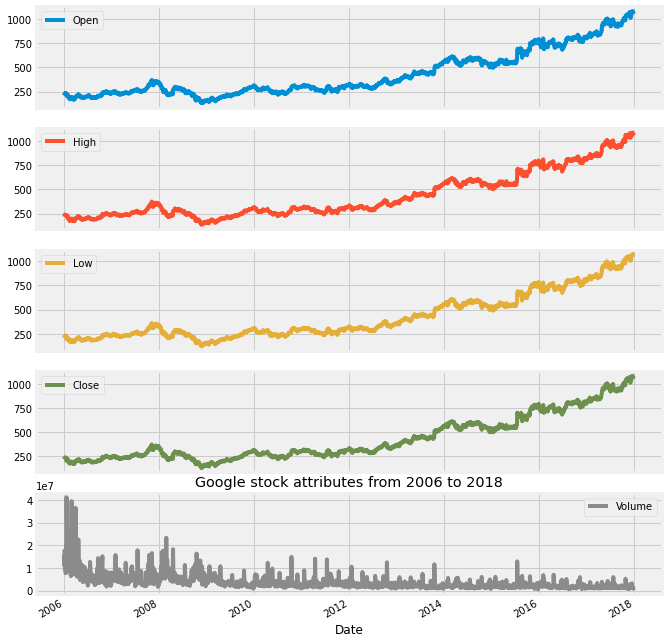

In [ ]:
google['2006':'2018'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2006 to 2018')
plt.savefig('stocks.png')
plt.show()

### Inference 
From the above figure, we can see the trend in google stocks for every feature like High,Low,Close,volume 

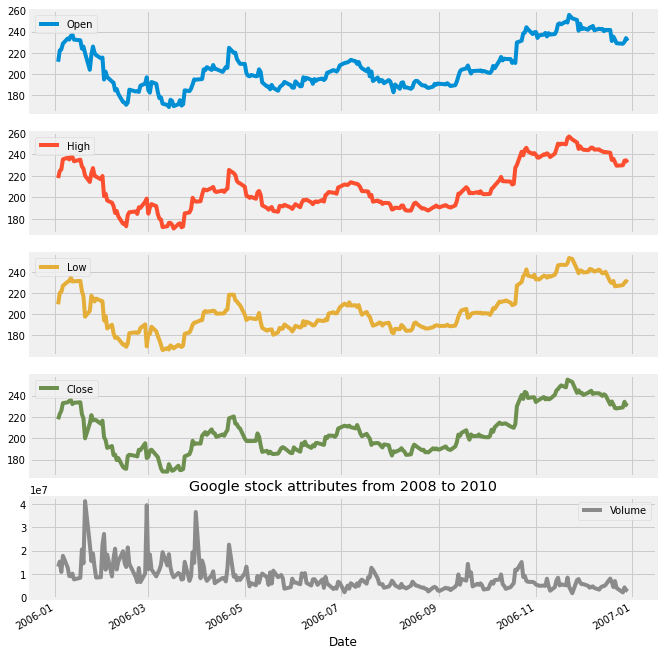

In [ ]:
# for single year
google['2006':'2006'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2008 to 2010')
plt.savefig('stocks.png')
plt.show()

## 1.4 Autocorrelation and Partial Autocorrelation
* Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
* Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags.  The terms can be interpreted the same way as a standard  linear regression, that is the contribution of a change in that particular lag while holding others constant. 



### Autocorrelation

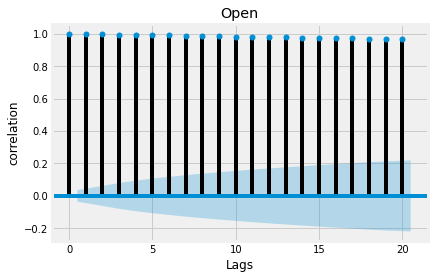

In [ ]:
# Autocorrelation of google of high
plot_acf(google["Open"],lags=20,title="Open",alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('correlation')
plt.show()

 As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.


### Partial Autocorrelation

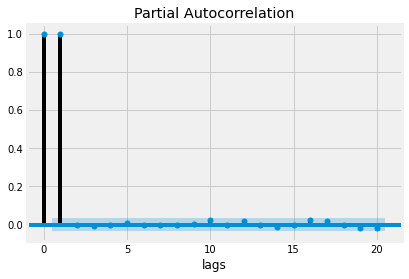

In [ ]:
# Partial Autocorrelation of google of High
plot_pacf(google["Open"],lags=20)
plt.xlabel('lags')
plt.show()

Though it is statistically signficant, partial autocorrelation after first 2 lags is very low.

## 1.5. Trends, seasonality and noise
These are the components of a time series
* Trend - Consistent upwards or downwards slope of a time series - this will help us to see clear pattern in data
* Seasonality - Clear periodic pattern of a time series(like sine funtion) - can know wthere the change is uniform or not
* Noise - Outliers or missing values - there may be some outliers due to unexpected events in particular time

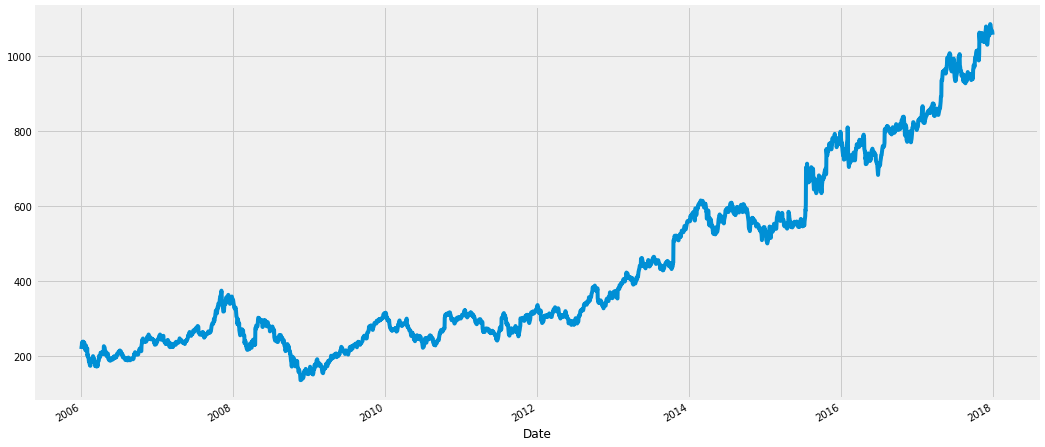

In [ ]:
# Let's take Google stocks High for this
google["High"].plot(figsize=(16,8))

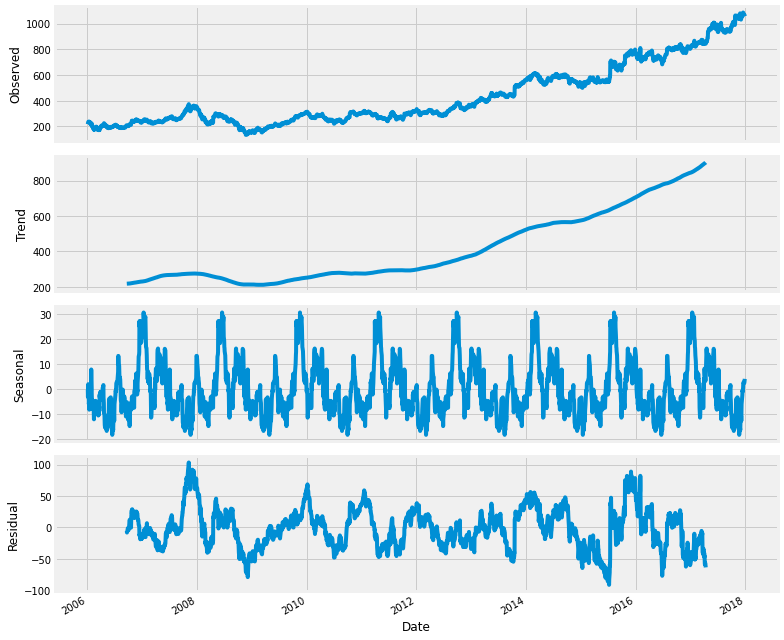

In [ ]:
# Now, for decomposition...
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"],freq=360) # The frequncy is annual
figure = decomposed_google_volume.plot()
plt.show()

* There is clearly an upward trend in the above plot.
* You can also see the uniform seasonal change.
* Non-uniform noise that represent outliers and missing values
* when the data has highly varying trend ,it is not stationary

# 2.Modelling using statstools and deep learning model

## For **Volumes** values of google stocks

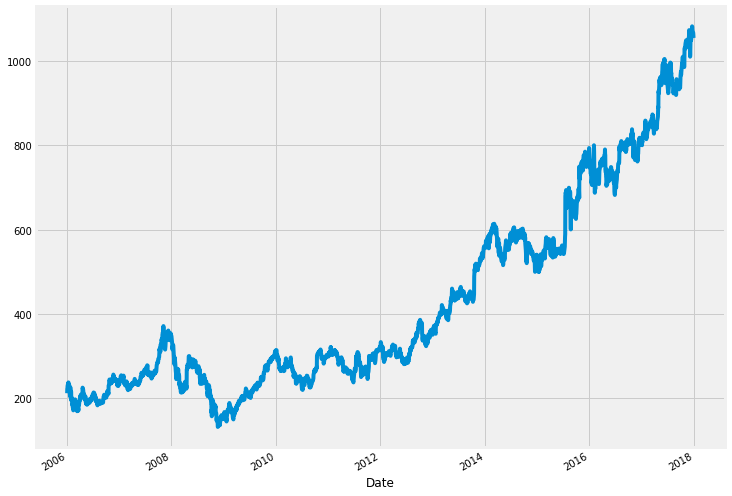

In [ ]:
# plot of opening data
google['Open'].plot()

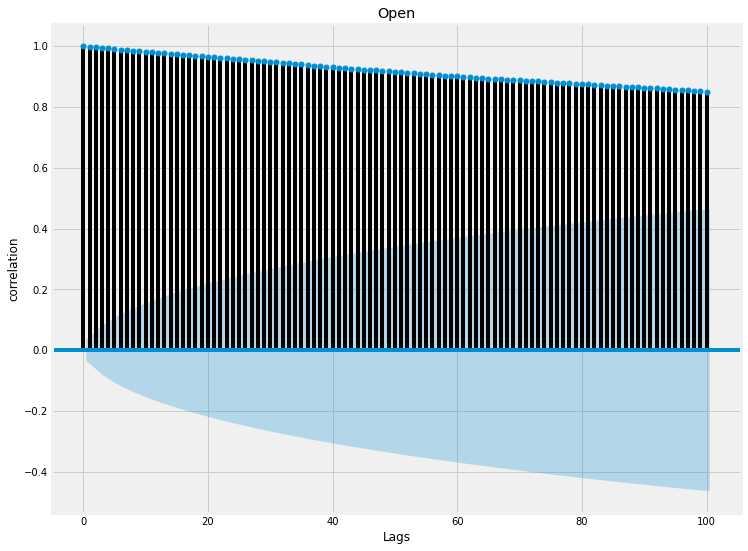

In [ ]:
# Autocorrelation of google of Volume
plot_acf(google['Open'],lags=100,title="Open",alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('correlation')
plt.show()

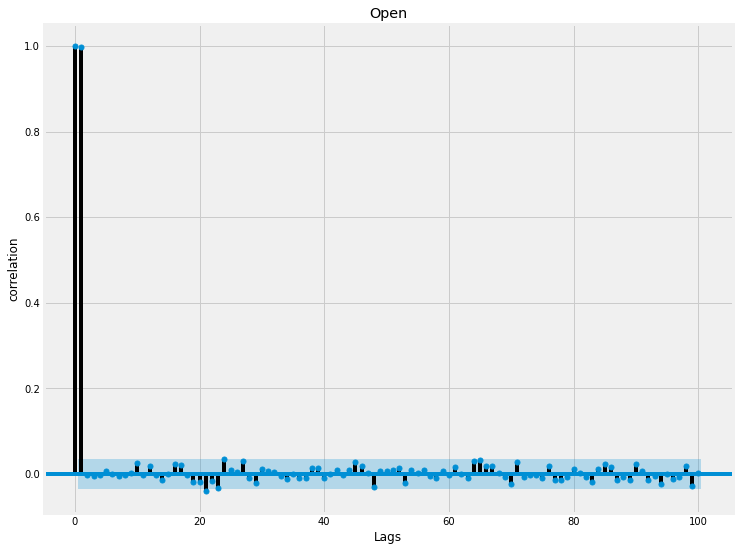

In [ ]:
# Autocorrelation of google of Volume
plot_pacf(google['Open'],lags=100,title="Open",alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('correlation')
plt.show()

when ACF graph gradually reduces and PACF graph suddenly cut down to 0 then we should generally prefer AR model and vice-versa for MA model <br/>
We have implemented all the models for comparision. <br/>

 We can observe PACF has also suddenly reached 0 , so we have to do both AR ,MA models to compare and see which one will work best

### 2.1.1 AR models

 #### AR(1) model
 R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ε<sub>t</sub>
 ##### As RHS has only one lagged value(R<sub>t-1</sub>)this is called AR model of order 1 where μ is mean and ε is noise at time t
 #### AR(2) model
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ε<sub>t</sub>
 #### AR(3) model
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ϕ<sub>3</sub>R<sub>t-3</sub> + ε<sub>t</sub>

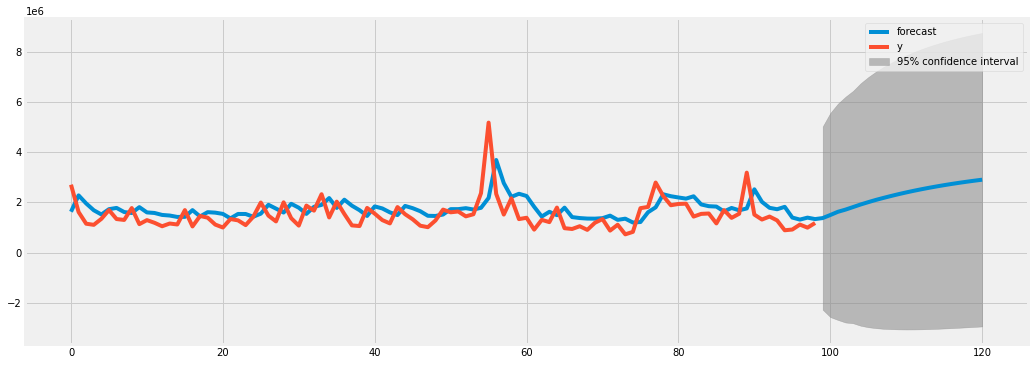

In [ ]:
# Predicting Opening value of google
# AR(1) model 
rcParams['figure.figsize'] = 16, 6
open_AR = ARMA(google['Volume'].iloc[1:].values, order=(5,0))
res_open_AR = open_AR.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_AR.plot_predict(start=3019-100,end=3019+20)
plt.show()

In [ ]:
rmse_open_AR = math.sqrt(mean_squared_error(google['Volume'].iloc[(3019-100):3019].values, res_open_AR.predict(start=(3019-100),end=3018)))
print("The root mean squared error is {}.".format(rmse_open_AR))

The root mean squared error is 375846.7181722891.


In [ ]:
print ( 'AR model summary for google Opening stock value ')
print(res_open_AR.summary())
print("μ={} ,θ={}".format(res_open_AR.params[0],res_open_AR.params[1:]))

AR model summary for google Opening stock value 
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(5, 0)   Log Likelihood              -47858.674
Method:                       css-mle   S.D. of innovations        1864689.052
Date:                Tue, 11 May 2021   AIC                          95731.348
Time:                        12:45:17   BIC                          95773.434
Sample:                             0   HQIC                         95746.482
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.548e+06   2.92e+05     12.140      0.000    2.98e+06    4.12e+06
ar.L1.y        0.4907      0.018     27.173      0.000       0.455       0.526
ar.

### 2.1.2 MA models

#### MA(1) model
R<sub>t</sub> = μ  +  ϵ<sub>t</sub>1 + θϵ<sub>t-1</sub> 

It translates to Today's returns = mean + today's noise + yesterday's noise
##### As there is only 1 lagged value in RHS, it is an MA model of order 1


#### MA(2) model
R<sub>t</sub> = μ  +  ϵ<sub>t</sub>1 + θ<sub>1</sub>ϵ<sub>t-1</sub> +  θ<sub>2</sub>ϵ<sub>t-2</sub> 

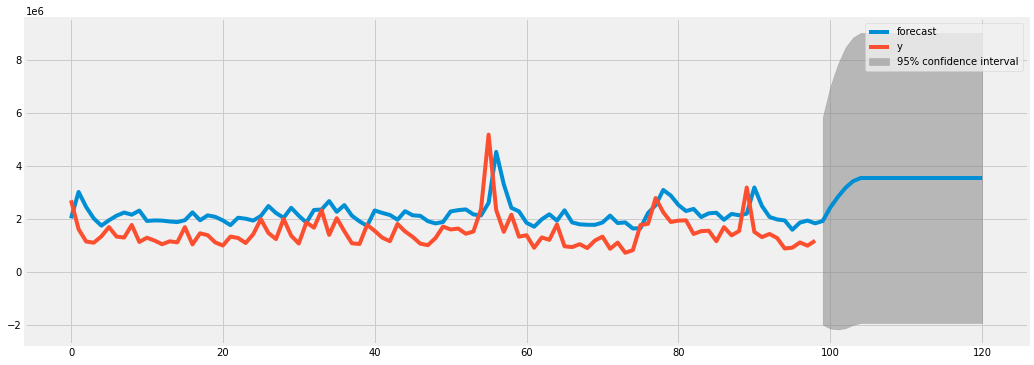

In [ ]:
# Forecasting and predicting Google opening value
rcParams['figure.figsize'] = 16, 6
model_open_MA = ARMA(google['Volume'].iloc[1:].values, order=(0,5))
res_open_MA = model_open_MA.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_MA.plot_predict(start=3019-100,end=3019+20)
plt.show()

In [ ]:
rmse_open_MA = math.sqrt(mean_squared_error(google['Volume'].iloc[(3019-100):3019].values, res_open_MA.predict(start=(3019-100),end=3018)))
print("The root mean squared error is {}.".format(rmse_open_MA))

The root mean squared error is 711384.9491066159.


In [ ]:
print ( 'MA model summary for google Opening stock value ')
print(res_open_MA.summary())
print("μ={} ,θ={}".format(res_open_MA.params[0],res_open_MA.params[1:]))


MA model summary for google Opening stock value 
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(0, 5)   Log Likelihood              -48061.717
Method:                       css-mle   S.D. of innovations        1994587.728
Date:                Tue, 11 May 2021   AIC                          96137.434
Time:                        12:45:18   BIC                          96179.521
Sample:                             0   HQIC                         96152.568
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.548e+06   1.11e+05     32.001      0.000    3.33e+06    3.77e+06
ma.L1.y        0.6034      0.018     33.286      0.000       0.568       0.639
ma.



### 2.1.3 ARMA models

### ARMA(1,1) model
### R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ϵ<sub>t</sub> + θϵ<sub>t-1</sub> 
Basically, Today's return = mean + Yesterday's return + noise + yesterday's noise.

### ARMA (2,2) model
### R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> +  ϕ<sub>2</sub>R<sub>t-2</sub>+ ϵ<sub>t</sub> + θ<sub>1</sub>ϵ<sub>t-1</sub>  +  θ<sub>2</sub>ϵ<sub>t-2</sub> 

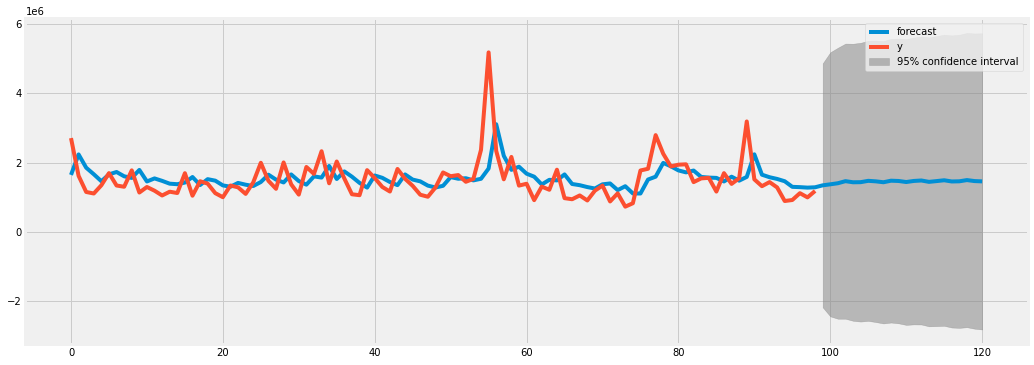

In [ ]:
# Forecasting and predicting Google opening value
rcParams['figure.figsize'] = 16, 6
model_open_ARMA = ARMA(google['Volume'].iloc[1:].values, order=(5,5))
res_open_ARMA = model_open_ARMA.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_ARMA.plot_predict(start=3019-100,end=3019+20)
plt.show()

In [ ]:
rmse_open_ARMA = math.sqrt(mean_squared_error(google['Volume'].iloc[(3019-100):3019].values, res_open_ARMA.predict(start=(3019-100),end=3018)))
print("The root mean squared error is {}.".format(rmse_open_ARMA))

The root mean squared error is 342862.02232960914.


In [ ]:
print(res_open_ARMA.summary())

print('Parameters:')
print('μ={},ϕ={},θ={}'.format(res_open_ARMA.params[0],res_open_ARMA.params[1:6],res_open_ARMA.params[6:11]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(5, 5)   Log Likelihood              -47750.024
Method:                       css-mle   S.D. of innovations        1798050.149
Date:                Tue, 11 May 2021   AIC                          95524.048
Time:                        12:51:19   BIC                          95596.196
Sample:                             0   HQIC                         95549.992
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.548e+06   5.72e+06      0.620      0.535   -7.66e+06    1.48e+07
ar.L1.y       -0.1110      0.128     -0.869      0.385      -0.361       0.139
ar.L2.y        0.3015      0.084      3.591      0.0

### 2.1.4 ARIMA models

ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter
### ARIMA(1,0,0)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub>**
### ARIMA(1,0,1)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>**
### ARIMA(1,1,1)
**Δy<sub>t</sub> = a<sub>1</sub>Δy<sub>t-1</sub> + a<sub>2</sub>Δy<sub>t-2</sub>+ ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub> + b<sub>2</sub>ϵ<sub>t-2</sub>** where **Δy<sub>t</sub> = y<sub>t</sub> - y<sub>t-1</sub>**

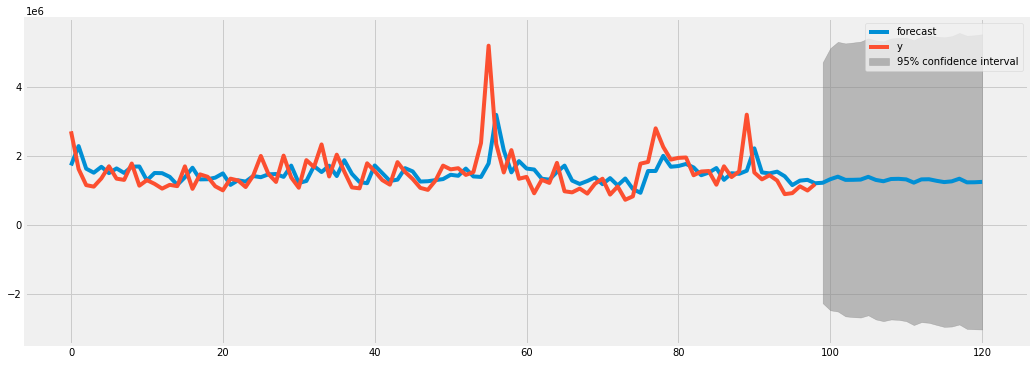

In [ ]:
rcParams['figure.figsize'] = 16, 6
# Forecasting and predicting Google Opening values
model_open_ARIMA = ARIMA(google['Volume'].iloc[1:].values, order=(5,1,5))
res_open_ARIMA = model_open_ARIMA.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_ARIMA.plot_predict(start=3019-100,end=3019+20)
plt.show()

In [ ]:
rmse_open_ARIMA = math.sqrt(mean_squared_error(google['Volume'].iloc[(3019-100):3019].values, res_open_ARIMA.predict(start=(3019-100),end=3018)))
print("The root mean squared error is {}.".format(rmse_open_ARIMA))

The root mean squared error is 1739477.3619196415.


In [ ]:
print(res_open_ARIMA.summary())

print('Parameters:')
print('μ={},ϕ={},θ={}'.format(res_open_ARIMA.params[0],res_open_ARIMA.params[1:6],res_open_ARIMA.params[6:11]))

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -47703.186
Method:                       css-mle   S.D. of innovations        1776956.681
Date:                Tue, 11 May 2021   AIC                          95430.373
Time:                        12:51:32   BIC                          95502.517
Sample:                             1   HQIC                         95456.315
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4677.4984   3483.097     -1.343      0.179   -1.15e+04    2149.246
ar.L1.D.y     -1.4094      0.001  -1826.729      0.000      -1.411      -1.408
ar.L2.D.y     -1.2491      0.021    -58.359      0.0

### 2.1.5 LSTM models

In [ ]:
# function which plots google stock prices: real and predicted both

def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="real GOOGLE stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("GOOGLE stock price prediction")
    plt.xlabel("time")
    plt.ylabel("GOOGLE stock price")
    plt.legend()
    plt.show()


In [ ]:
train = google['Volume'][:'2016'].values.reshape(-1,1)
test = google['Volume']['2017':].values.reshape(-1,1)
train

array([[13137450],
       [15292353],
       [10815661],
       ...,
       [ 1214756],
       [ 1057392],
       [ 1735879]])

In [ ]:
# scaling the training set

sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
test_scaled = sc.fit_transform(test)
train_scaled

array([[0.31027463],
       [0.36327046],
       [0.25317456],
       ...,
       [0.01705817],
       [0.0131881 ],
       [0.02987422]])

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements

x_train = []
y_train = []

for i in range(120,2768):
    x_train.append(train_scaled[i-120:i, 0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# reshaping x_train for efficient modelling

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# LSTM architecture

regressor = Sequential()

# add first layer with dropout

regressor.add(LSTM(units=120, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))

# add second layer

regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(Dropout(0.2))

# add third layer

regressor.add(LSTM(units=60, return_sequences=True))
regressor.add(Dropout(0.2))

# add fourth layer

regressor.add(LSTM(units=40))
regressor.add(Dropout(0.2))

# the output layer

regressor.add(Dense(units=1))

In [ ]:
# compiling the LSTM RNN network

regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# fit to the training set

regressor.fit(x_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
83/83 [==============================] - 32s 302ms/step - loss: 0.0035
Epoch 2/10
83/83 [==============================] - 25s 304ms/step - loss: 0.0020
Epoch 3/10
83/83 [==============================] - 25s 303ms/step - loss: 0.0018
Epoch 4/10
83/83 [==============================] - 25s 303ms/step - loss: 0.0019
Epoch 5/10
83/83 [==============================] - 25s 303ms/step - loss: 0.0021
Epoch 6/10
83/83 [==============================] - 25s 304ms/step - loss: 0.0017
Epoch 7/10
83/83 [==============================] - 25s 303ms/step - loss: 0.0018
Epoch 8/10
83/83 [==============================] - 25s 303ms/step - loss: 0.0015
Epoch 9/10
83/83 [==============================] - 25s 305ms/step - loss: 0.0017
Epoch 10/10
83/83 [==============================] - 25s 298ms/step - loss: 0.0014


In [ ]:


inputs = sc.transform(test)
print(inputs.shape)


(251, 1)


In [ ]:
# preparing x_test

x_test = []
y_test = []
for i in range(120,251):
    x_test.append(inputs[i-120:i, 0])
    y_test.append(inputs[i,0])
    
x_test,y_test = np.array(x_test) , np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(131, 120, 1)

In [ ]:
# predicting the stock prices for test set
predicted = regressor.predict(x_test)
print(predicted[0])
predicted = sc.inverse_transform(predicted)
print(predicted[0])

[0.18161169]
[1672496.2]


In [ ]:
y_test = sc.inverse_transform(y_test.reshape(-1,1))

In [ ]:
regressor.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 120, 120)          58560     
_________________________________________________________________
dropout_36 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 120, 80)           64320     
_________________________________________________________________
dropout_37 (Dropout)         (None, 120, 80)           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 120, 60)           33840     
_________________________________________________________________
dropout_38 (Dropout)         (None, 120, 60)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 40)               

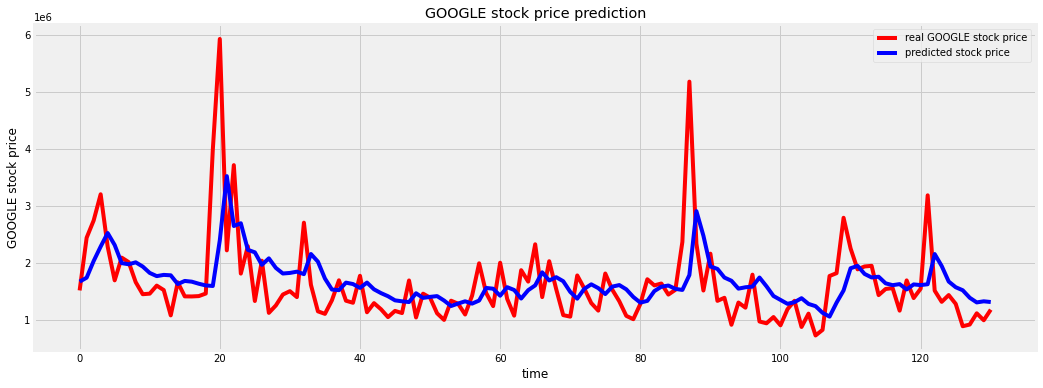

In [ ]:
# visualizing the results: predicted vs test
rcParams['figure.figsize'] = 16, 6
test = data.values
plot_predictions(y_test, predicted)

In [ ]:
rmse_LSTM =  math.sqrt(mean_squared_error(y_test, predicted))
print(rmse_LSTM)

675420.7032834892


###  2.1.6 Comparision of models 

We have used 'rmse' as the parameter to compare 5 models

In [ ]:
print('rmse of AR(5) model        : ',rmse_open_AR)
print('rmse of MA(5) model        : ',rmse_open_MA)
print('rmse of ARMA(5,5) model    : ',rmse_open_ARMA)
print('rmse of ARIMA(5,1,5) model : ',rmse_open_ARIMA)
print('rmse of LSTM model         : ',rmse_LSTM)

rmse of AR(5) model        :  375846.7181722891
rmse of MA(5) model        :  711384.9491066159
rmse of ARMA(5,5) model    :  342862.02232960914
rmse of ARIMA(5,1,5) model :  1739477.3619196415
rmse of LSTM model         :  675420.7032834892


We can observe that ARMA(5,5) has less RMSE value , let's see the final model
<br/>
We can also see that AR(5) model is also equally better as rmse values are so close to each other

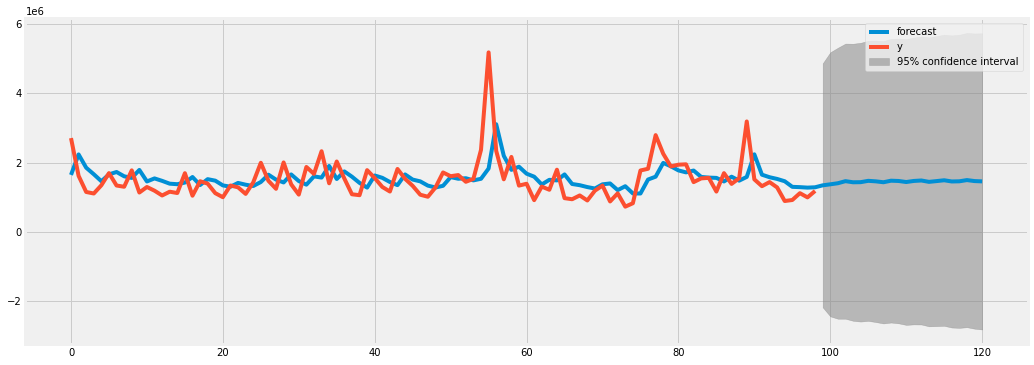

In [ ]:
# Forecasting and predicting Google opening value
rcParams['figure.figsize'] = 16, 6
model_open_ARMA = ARMA(google['Volume'].iloc[1:].values, order=(5,5))
res_open_ARMA = model_open_ARMA.fit()

# let's predict for last 1 year of data provided and next 20 days
res_open_ARMA.plot_predict(start=3019-100,end=3019+20)
plt.show()